In [48]:
#imports
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from lxml import etree
import os
from bs4 import BeautifulSoup
import requests
import xml.etree.ElementTree as ET
import validators
import datetime
import re
import string
import nltk
from nltk.corpus import stopwords

from collections import Counter

In [2]:
#downloads
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('rslp')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caperei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\caperei\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\caperei\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\caperei\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
#parameters
characters_for_name=60
legislature='dar/01'
cycle='14'

stop_words_nltk = nltk.corpus.stopwords.words('portuguese')
#stop_words = ["the","it","she","he", "a"] #Uncomment this line if you want to use your own list of stopwords.
#The stemmers and lemmers need to be initialized before bing run
#porter = nltk.stem.porter.PorterStemmer()
snowball = nltk.stem.snowball.SnowballStemmer('portuguese')
#wordnet = nltk.stem.WordNetLemmatizer()
#RSLP=nltk.stem.RSLPStemmer()

In [4]:
#utils

def add_zeros(int_):
    if len(str(int_))<2:
        return '00'+str(int_)
    if len(str(int_))<3:
        return '0'+str(int_)
    if len(str(int_))==3:
        return str(int_)

def get_text_from_html(url__):
    from bs4 import BeautifulSoup
    res = requests.get(url__)
    html_page = res.content
    soup = BeautifulSoup(html_page, 'html.parser')
    return str(soup.noscript)

def read_input_table(current_directory="C:\\Users\caperei",cycle='14',session='1' ):

    data_directory=f"\portuguese_open_data\data\cycle\{cycle}\session\{session}\\numbers_dates_pages.csv"
    input_data=pd.read_csv(r"C:\Users\caperei\portuguese_open_data\data\cyle\14\session\1\numbers_dates_pages.csv")
    return input_data

In [5]:
#regex
def check_dialog(text_):
    pat="(?:</p><p>.*?\(.*?\): —)"
    match=re.findall(pat, text_)
    if match is None :
        return 'no_dialog'
    else:
        for m in match:
            
            return m

def extract_dialog(full_text,characters_for_name):    
    if full_text is None:
        return None
    else:
        dialogs=[(m.start(0), m.end(0)) for m in re.finditer('</p><p></p><p>(.+?): —', full_text)]
        out=[]
        if len(dialogs)==1:
            out.append(full_text[dialogs[0][1]-characters_for_name:])
        if len(dialogs)>1:
            for i in range(0, len(dialogs)-1):
                out.append(full_text[dialogs[i][1]-characters_for_name:dialogs[i+1][0]])
            out.append(full_text[dialogs[len(dialogs)-1][1]-50:])
        return out

    
def extract_party_name(dialogs):
    if dialogs is None:
        return None
    else:
        res=[]
        for i in dialogs:
                    positions=[(m.start(0), m.end(0)) for m in re.finditer('\((.+?)\): —', i)]
                    if len(positions)==0:
                        res.append(['No','No'])
                    else:
                        party=re.findall('\((.+?)\)',i)
                        name_aux=i[positions[0][1]-50:positions[0][1]]
                        name=re.sub(r'\b\w{1,2}\b', '', name_aux).replace('.','').replace ('()','').replace('  ','').replace('<','').replace('>','').replace('/','').replace(': —','')
                        if len(party)>0:
                            party=party[0]
                        res.append([party,name])
        return res

def add_speech_next_page(df):
    for pi in range(1,df.page.max()+1):
        if len(df[df.page==pi].speech.values[0])>0:
            speeches=df[df.page==pi].speech.values[0]
            if '</noscript>' in speeches[-1]:
                
                for n in range(1,df.page.max()-pi):
                    if ': —' in df[df.page==pi+n].text_1.values[0]:
                        
                        in_=df[df.page==pi+n].text_1.values[0].find(': —')
                        df[df.page==pi].speech.values[0][-1]=df[df.page==pi].speech.values[0][-1]+' '+str(df[df.page==pi+n].text_1.values[0][0:in_])
                        
                        break
                    else:
                        
                        df[df.page==pi].speech.values[0][-1]=df[df.page==pi].speech.values[0][-1]+' '+str(df[df.page==pi+n].text_1.values[0])
    return df


#defining the function to remove punctuation
def remove_punctuation(text):
  if(type(text)==float):
    return text
  ans=""  
  for i in text:     
    if i not in string.punctuation+'<p></p>ºª':
      ans+=i    
  return ans

def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)
         
    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

def generate_N_grams(text,ngram=1):
  words=[word for word in text]  
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans

In [6]:
#functions scrapping
def build_transcripts_table_from_html(session=['01'],legislature='dar/01', cycle='14'):
    df = pd.DataFrame(columns=['legislature','cycle','session','number','date','page', 'text_1','url'])        
    #session=['01'] #['01','02','03']
    numbers_dates=list(zip(input_data.number, input_data.date,input_data.pages )) #[0:1]
    pages=input_data.pages.values #[0:1]
    s_c=[]
    n_c=[]
    d_c=[]
    p_c=[]
    u_c=[]
    t_c=[]
    for s in session:
        for number, date, page in numbers_dates:
            number=add_zeros(number)
            date=datetime.datetime.strptime(date, '%d/%m/%Y').strftime('%Y-%m-%d')
            for page_i in range(1,page+1):
                    url_=f'https://debates.parlamento.pt/catalogo/r3/{legislature}/{cycle}/{s}/{number}/{date}/{page_i}'
                    if validators.url(url_):
                        #print (url_)
                        u_c.append(url_)
                        p_c.append(page_i)
                        t_c.append(get_text_from_html(url_))
                        s_c.append(s)
                        n_c.append(number)
                        d_c.append(date)
    df['page']=p_c
    df['session']=s_c
    df['number']=n_c
    df['date']=d_c

    df['text_1']=t_c
    df['url']=u_c
    df['legislature']=legislature
    df['cycle']=cycle    
    return df

def add_party_speaker(df,characters_for_name ):
    #add columns
    df['speech']=[extract_dialog(t,characters_for_name) for t in df.text_1 ]
    df['party']=[extract_party_name(t) for t in df.speech ]
    df=add_speech_next_page(df)
    #re arrange by speaker and party
    df1=df.explode(['speech', 'party']).reset_index(drop=True)
    df2=df1.dropna(subset=['party'])
    df2['party_s']=[t[0] for t in df2.party]
    df2['speaker']=[t[1] for t in df2.party]
    df2=df2[df2.party_s!='No']
    return df2

In [7]:
input_data=read_input_table()
input_data.head(3)

,number,date,pages
0,1,25/10/2019,13
1,2,30/10/2019,124
2,3,31/10/2019,26


In [8]:
#=build_transcripts_table_from_html()
#df.to_pickle('portuguese_transcripts_s1.pkl') 
df = pd.read_pickle('portuguese_transcripts_s1.pkl')

In [9]:
df.head()

,legislature,cycle,session,number,date,page,text_1,url,speech,party
0,dar/01,14,01,001,2019-10-25,1,"<noscript>\n<p>Sábado, 26 de outubro de 2019 ...",https://debates.parlamento.pt/catalogo/r3/dar/...,[],[]
1,dar/01,14,01,001,2019-10-25,2,<noscript>\n<p>I SÉRIE — NÚMERO 1 </p><p></p><...,https://debates.parlamento.pt/catalogo/r3/dar/...,[es.</p><p></p><p>A Sr.ª Ana Catarina Mendonça...,"[[PS, Ana Catarina Mendonça Mendes ], [No, No]..."
2,dar/01,14,01,001,2019-10-25,3,<noscript>\n<p>26 DE OUTUBRO DE 2019 </p><p>3 ...,https://debates.parlamento.pt/catalogo/r3/dar/...,"[er votado, Sr. Presidente. </p><p></p><p>O Sr...","[[No, No], [PS, Pedro Delgado Alves ]]"
3,dar/01,14,01,001,2019-10-25,4,<noscript>\n<p>I SÉRIE — NÚMERO 1 </p><p></p><...,https://debates.parlamento.pt/catalogo/r3/dar/...,[],[]
4,dar/01,14,01,001,2019-10-25,5,<noscript>\n<p>26 DE OUTUBRO DE 2019 </p><p>5 ...,https://debates.parlamento.pt/catalogo/r3/dar/...,"[residente, muito obrigado. </p><p></p><p>O Sr...","[[No, No]]"


In [10]:
df2=add_party_speaker(df,characters_for_name )

<ipython-input-6-99982d4d3f5c>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['party_s']=[t[0] for t in df2.party]
<ipython-input-6-99982d4d3f5c>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['speaker']=[t[1] for t in df2.party]


In [11]:
df2['speech1']= df2['speech'].apply(lambda x:remove_punctuation(x))
df2['tokenized_text'] = df2['speech1'].apply(lambda x: nltk.word_tokenize(x))
df2['normalized_tokens'] = df2['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))
df2['normalized_tokens_count'] = df2['normalized_tokens'].apply(lambda x: len(x))
df2['uni_grams'] = df2['normalized_tokens'].apply(lambda x: generate_N_grams(x,1))
df2['bi_grams'] = df2['normalized_tokens'].apply(lambda x: generate_N_grams(x,2))
df2['tri_grams'] = df2['normalized_tokens'].apply(lambda x: generate_N_grams(x,3))

In [12]:
#df2.party_s.unique()
parties=['PS', 'PSD', 'BE', 'PCP', 'CDS-PP', 'PAN', 'PEV','CH','IL','L','CDS','PCP']
df3=df2[df2.party_s.isin(parties)]

In [13]:
df3.head(3)

,legislature,cycle,session,number,date,page,text_1,url,speech,party,party_s,speaker,speech1,tokenized_text,normalized_tokens,normalized_tokens_count,uni_grams,bi_grams,tri_grams
1,dar/01,14,01,001,2019-10-25,2,<noscript>\n<p>I SÉRIE — NÚMERO 1 </p><p></p><...,https://debates.parlamento.pt/catalogo/r3/dar/...,es.</p><p></p><p>A Sr.ª Ana Catarina Mendonça ...,"[PS, Ana Catarina Mendonça Mendes ]",PS,Ana Catarina Mendonça Mendes,esA Sr Ana Catarina Mendonça Mendes PS — Sras ...,"[esA, Sr, Ana, Catarina, Mendonça, Mendes, PS,...","[esa, sr, ana, catarin, mendonc, mend, ps, sra...",90,"[esa, sr, ana, catarin, mendonc, mend, ps, sra...","[esa sr, sr ana, ana catarin, catarin mendonc,...","[esa sr ana, sr ana catarin, ana catarin mendo..."
5,dar/01,14,01,001,2019-10-25,3,<noscript>\n<p>26 DE OUTUBRO DE 2019 </p><p>3 ...,https://debates.parlamento.pt/catalogo/r3/dar/...,o. </p><p></p><p>O Sr. Pedro Delgado Alves (PS...,"[PS, Pedro Delgado Alves ]",PS,Pedro Delgado Alves,o O Sr Pedro Delgado Alves PS — Sr Presidente ...,"[o, O, Sr, Pedro, Delgado, Alves, PS, —, Sr, P...","[sr, pedr, delg, alves, ps, sr, president, sra...",682,"[sr, pedr, delg, alves, ps, sr, president, sra...","[sr pedr, pedr delg, delg alves, alves ps, ps ...","[sr pedr delg, pedr delg alves, delg alves ps,..."
12,dar/01,14,01,001,2019-10-25,8,<noscript>\n<p>I SÉRIE — NÚMERO 1 </p><p></p><...,https://debates.parlamento.pt/catalogo/r3/dar/...,</p><p>A Sr.ª Ana Catarina Mendonça Mendes (PS...,"[PS, Ana Catarina Mendonça Mendes ]",PS,Ana Catarina Mendonça Mendes,A Sr Ana Catarina Mendonça Mendes PS — Sr Pres...,"[A, Sr, Ana, Catarina, Mendonça, Mendes, PS, —...","[sr, ana, catarin, mendonc, mend, ps, sr, pres...",271,"[sr, ana, catarin, mendonc, mend, ps, sr, pres...","[sr ana, ana catarin, catarin mendonc, mendonc...","[sr ana catarin, ana catarin mendonc, catarin ..."


In [14]:
right=[ 'PSD',  'CDS-PP', 'CH','IL','CDS']
left=[ 'PS', 'BE', 'PCP', 'PAN', 'PEV','L','PCP']


def create_frequency_table_grams(n_gram=1, input=df3, right_parties=right, left_parties=left):
    grams_d={1: 'uni_grams', 2: 'bi_grams', 3: 'tri_grams'}
   

    r_grams=[item for sublist in df3[df3.party_s.isin(right)][grams_d[n_gram]] for item in sublist]
    l_grams=[item for sublist in df3[df3.party_s.isin(left)][grams_d[n_gram]] for item in sublist]

    total_counter = Counter([item for sublist in df3[grams_d[n_gram]] for item in sublist])
    right_counter = Counter(r_grams)
    left_counter = Counter(l_grams)

    df_all = pd.DataFrame.from_dict(total_counter, orient='index').reset_index()
    df_all.columns=['phrase','count']
    df_all['f_right']=[right_counter[x] for x in df_all.phrase]
    df_all['f_left']=[left_counter[x] for x in df_all.phrase]


    df_all['f_left_total']=sum(left_counter.values())
    df_all['f_right_total']=sum(right_counter.values())
    df_all['f_right_minus']=(df_all['f_right']- df_all['f_right_total'])/df_all['f_right_total']
    df_all['f_left_minus']=(df_all['f_left']- df_all['f_left_total'])/df_all['f_left_total']

    df_all['f_right_norm']=df_all['f_right']/df_all['f_right_total']
    df_all['f_left_norm']=df_all['f_left']/df_all['f_left_total']

    df_all['f_right_minus_norm']=df_all['f_right_minus']/df_all['f_right_total']
    df_all['f_left_minus_norm']=df_all['f_left_minus']/df_all['f_left_total']

    return df_all


def calculate_pearson(df_all):
    aa=df_all['f_right_norm']*df_all['f_left_minus_norm'] 
    bb=df_all['f_left_norm']*df_all['f_right_minus_norm']
    cc=aa-bb
    dd=cc*cc
    d11=df_all['f_right_norm']+df_all['f_left_norm']
    d22=df_all['f_right_norm']+df_all['f_right_minus_norm']
    d33=df_all['f_left_norm']+df_all['f_left_minus_norm']
    d44=df_all['f_right_minus_norm']+df_all['f_left_minus_norm']
    denom=d11*d22*d33*d44
    pp=dd/denom
    return pp

In [15]:
dfg=create_frequency_table_grams(n_gram=1, input=df3, right_parties=right, left_parties=left)
dfg2=create_frequency_table_grams(n_gram=2, input=df3, right_parties=right, left_parties=left)
dfg3=create_frequency_table_grams(n_gram=3, input=df3, right_parties=right, left_parties=left)


In [16]:
dfg2.to_pickle('dfg2.pkl') 
dfg3.to_pickle('dfg3.pkl') 

In [17]:
dfg['pearson_quad']=calculate_pearson(dfg)
dfg2['pearson_quad']=calculate_pearson(dfg2)
dfg3['pearson_quad']=calculate_pearson(dfg3)

In [18]:
trigrams_table=dfg3[dfg3.pearson_quad>0]
bigrams_table=dfg2[dfg2.pearson_quad>0]
unigrams_table=dfg[dfg.pearson_quad>0]

In [19]:
unigrams_table

,phrase,count,f_right,f_left,f_left_total,f_right_total,f_right_minus,f_left_minus,f_right_norm,f_left_norm,f_right_minus_norm,f_left_minus_norm,pearson_quad
20,cabem,3,0,3,463457,268386,-1.0,-0.999994,0.0,0.000006,-0.000004,-0.000002,0.949910
37,intuiçã,1,0,1,463457,268386,-1.0,-0.999998,0.0,0.000002,-0.000004,-0.000002,293495.409252
61,cessant,1,0,1,463457,268386,-1.0,-0.999998,0.0,0.000002,-0.000004,-0.000002,293495.409252
95,xiv,4,0,4,463457,268386,-1.0,-0.999991,0.0,0.000009,-0.000004,-0.000002,0.844365
113,seguid,3,0,3,463457,268386,-1.0,-0.999994,0.0,0.000006,-0.000004,-0.000002,0.949910
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,serrã,1,0,1,463457,268386,-1.0,-0.999998,0.0,0.000002,-0.000004,-0.000002,293495.409252
14989,demorous,1,0,1,463457,268386,-1.0,-0.999998,0.0,0.000002,-0.000004,-0.000002,293495.409252
14990,desidrat,1,0,1,463457,268386,-1.0,-0.999998,0.0,0.000002,-0.000004,-0.000002,293495.409252
14991,conhecems,1,0,1,463457,268386,-1.0,-0.999998,0.0,0.000002,-0.000004,-0.000002,293495.409252


In [29]:
def create_phrase_partisanship(df):
    aa=df['f_right_norm']+df['f_left_norm']
    df['rho']=df['f_right_norm']/aa
    bb=1-df['f_right_norm']
    df['f_left_norm_scaled']=df['f_right_norm']/bb
    cc=1-df['f_left_norm']
    df['f_right_norm_scaled']=df['f_left_norm']/cc
    df['pi']=df['f_right_norm']*df['rho']
    df['pi_scaled']=(df['pi']/(1-df['f_right_norm']))+((1-df['pi'])/(1-df['f_left_norm']))

    df['gram_partisanship']= 0.5 * (1 - df['pi_scaled'] + 
                           (df['f_right_norm_scaled'] +  df['f_left_norm_scaled']) * df['rho'])
    return df

In [50]:
def create_polarization_correlation(df):
    
    aa=df['f_left_norm']*-1
    bb= df['f_right_norm']*1
    df['beta_polarization']=aa+bb

    return df

In [51]:
trigrams_table=create_phrase_partisanship(trigrams_table)
trigrams_table=create_polarization_correlation(trigrams_table)

In [52]:
trigrams_table.sort_values(by='gram_partisanship',ascending=False)

,phrase,count,f_right,f_left,f_left_total,f_right_total,f_right_minus,f_left_minus,f_right_norm,f_left_norm,...,f_left_minus_norm,pearson_quad,rho,f_left_norm_scaled,unity,f_right_norm_scaled,pi,pi_scaled,gram_partisanship,beta_polarization
6061,cotrim figueired il,332,332,0,449495,258164,-0.998714,-1.000000,0.001286,0.000000,...,-0.000002,0.366214,1.0,0.001288,1,0.000000,0.001286,1.000002,0.000643,0.001286
6059,sr joã cotrim,332,332,0,449495,258164,-0.998714,-1.000000,0.001286,0.000000,...,-0.000002,0.366214,1.0,0.001288,1,0.000000,0.001286,1.000002,0.000643,0.001286
6063,il sr president,183,183,0,449495,258164,-0.999291,-1.000000,0.000709,0.000000,...,-0.000002,0.366982,1.0,0.000709,1,0.000000,0.000709,1.000001,0.000354,0.000709
6062,figueired il sr,175,175,0,449495,258164,-0.999322,-1.000000,0.000678,0.000000,...,-0.000002,0.367067,1.0,0.000678,1,0.000000,0.000678,1.000000,0.000339,0.000678
1588,cdspp muit bem,101,101,0,449495,258164,-0.999609,-1.000000,0.000391,0.000000,...,-0.000002,0.368552,1.0,0.000391,1,0.000000,0.000391,1.000000,0.000196,0.000391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12556,sr joã dias,151,0,151,449495,258164,-1.000000,-0.999664,0.000000,0.000336,...,-0.000002,0.639497,0.0,0.000000,1,0.000336,0.000000,1.000336,-0.000168,-0.000336
9205,sr paul sant,172,0,172,449495,258164,-1.000000,-0.999617,0.000000,0.000383,...,-0.000002,0.638988,0.0,0.000000,1,0.000383,0.000000,1.000383,-0.000191,-0.000383
2871,paul corr ps,174,0,174,449495,258164,-1.000000,-0.999613,0.000000,0.000387,...,-0.000002,0.638946,0.0,0.000000,1,0.000387,0.000000,1.000387,-0.000194,-0.000387
2869,sr joã paul,181,0,181,449495,258164,-1.000000,-0.999597,0.000000,0.000403,...,-0.000002,0.638807,0.0,0.000000,1,0.000403,0.000000,1.000403,-0.000201,-0.000403


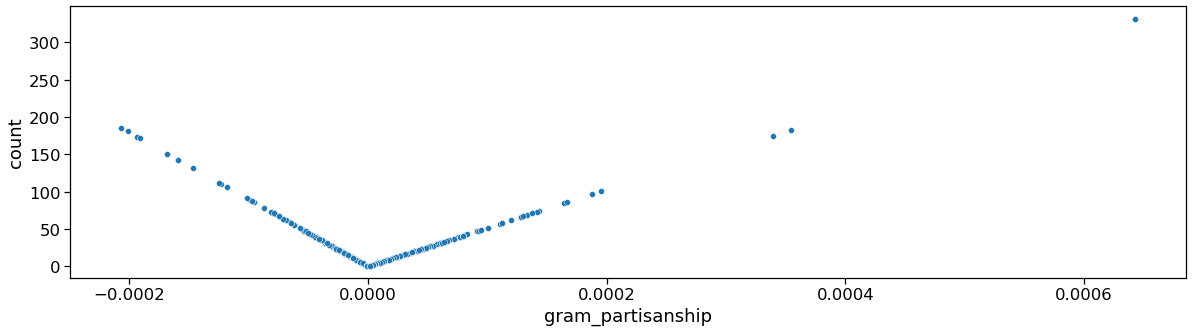

In [39]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
with sns.plotting_context("notebook",font_scale=1.5):
    sns.scatterplot(x="gram_partisanship",y='count',s=100,
                data=trigrams_table)

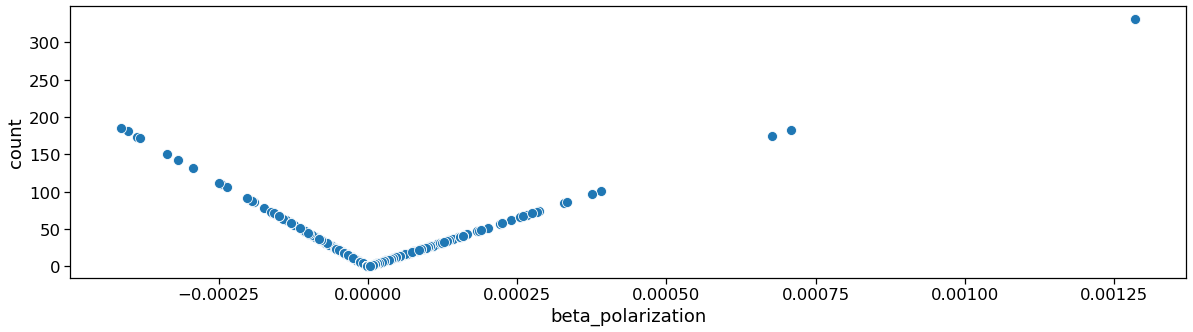

In [53]:
plt.figure(figsize=(20,5))
with sns.plotting_context("notebook",font_scale=1.5):
    sns.scatterplot(x="beta_polarization",y='count',s=100,
                data=trigrams_table)

<AxesSubplot:>

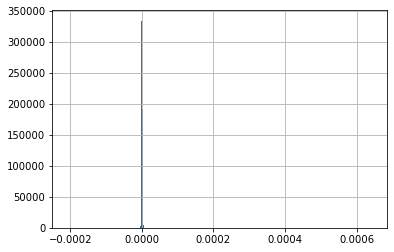

In [45]:
trigrams_table['gram_partisanship'].hist(bins = 500)